"""
Ahora que tienes la extensión de Python y el entorno virtual configurado, selecciona el entorno adecuado:

Abre la paleta de comandos (Ctrl+Shift+P).
Escribe Python: Select Interpreter y selecciona esta opción.
En la lista de entornos, selecciona el entorno virtual o la instalación específica de Python que desees usar.


In [2]:
from mpi4py import MPI 
import dolfinx # FEM in python
import matplotlib.pyplot as plt
import ufl # variational formulations
import numpy as np
import gmsh
import basix.ufl
import dolfinx.fem as fem
import dolfinx.fem.petsc
import utils

In [3]:
import pyvista # visualisation in python notebook
pyvista.start_xvfb()
pyvista.set_jupyter_backend("static")

# Material

In [4]:
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
nu_i = 0.3 # Poisson's ratio in inclusion

Parameters of the simulation

In [5]:
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0
mesh_size = 0.2*R_i
mesh_order = 1

mesh_comm = MPI.COMM_WORLD
model_rank = 0
gmsh.initialize()
facet_names = {"inner_boundary": 1, "outer_boundary": 2}
cell_names = {"inclusion": 1, "matrix": 2}
model = gmsh.model()
model.add("Disk")
model.setCurrent("Disk")
gdim = 2 # geometric dimension of the mesh
inner_disk = gmsh.model.occ.addDisk(0, 0, 0, R_i, aspect_ratio * R_i)
outer_disk = gmsh.model.occ.addDisk(0, 0, 0, R_e, R_e)
whole_domain = gmsh.model.occ.fragment(
            [(gdim, outer_disk)], [(gdim, inner_disk)]
        )
gmsh.model.occ.synchronize()
# Add physical tag for bulk
inner_domain = whole_domain[0][0]
outer_domain = whole_domain[0][1]
model.addPhysicalGroup(gdim, [inner_domain[1]], tag=cell_names["inclusion"])
model.setPhysicalName(gdim, inner_domain[1], "Inclusion")
model.addPhysicalGroup(gdim, [outer_domain[1]], tag=cell_names["matrix"])
model.setPhysicalName(gdim, outer_domain[1], "Matrix")

# Add physical tag for boundaries
lines = gmsh.model.getEntities(dim=1)
inner_boundary = lines[1][1]
outer_boundary = lines[0][1]
gmsh.model.addPhysicalGroup(1, [inner_boundary], facet_names["inner_boundary"])
gmsh.model.addPhysicalGroup(1, [outer_boundary], facet_names["outer_boundary"])
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",mesh_size)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",mesh_size)
model.mesh.generate(gdim)
gmsh.option.setNumber("General.Terminal", 1)
model.mesh.setOrder(mesh_order)
gmsh.option.setNumber("General.Terminal", 0)

# Import the mesh in dolfinx
from dolfinx.io import gmshio
domain, cell_tags, facet_tags = gmshio.model_to_mesh(model, mesh_comm, model_rank, gdim=gdim)
domain.name = "composite"
cell_tags.name = f"{domain.name}_cells"
facet_tags.name = f"{domain.name}_facets"
gmsh.finalize()



Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.00519599s, CPU 0.004367s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.495494s, CPU 0.405024s)
Info    : 4554 nodes 9140 elements


In [6]:
cell_names["matrix"]
cell_names["inclusion"]

1

Questions start here

0) Export the mesh as a xdmf file and open it in Paraview

In [7]:
# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/mesh.xdmf", "w") as file:
    file.write_mesh(domain)
    domain.topology.create_connectivity(1, 2)

1) Plot the mesh with a color code to locate the inclusion and the matrix

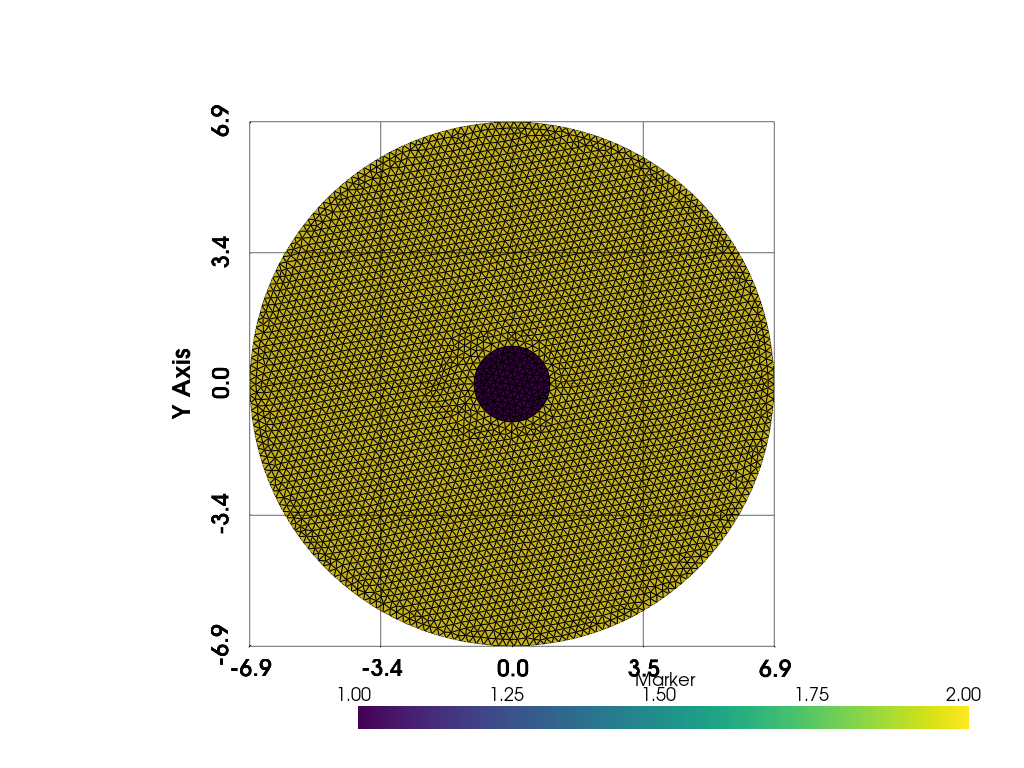

In [12]:
topology, cells, geometry = dolfinx.plot.vtk_mesh(domain)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
function_grid["Marker"] = cell_tags.values
plotter = pyvista.Plotter()
plotter.add_mesh(function_grid, show_edges=True)
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.view_xy()
plotter.save_graphic('figure.pdf')
plotter.show()

# 2) Define integral over the two domains domains

In [7]:
ds = ufl.Measure("ds", domain = domain,subdomain_data = cell_tags)
dx = ufl.Measure("dx", domain = domain, subdomain_data = cell_tags)
one = dolfinx.fem.Constant(domain,dolfinx.default_scalar_type(1.))

In [38]:
one = dolfinx.fem.Constant(domain,dolfinx.default_scalar_type(1.))
area_domain = utils.assemble_scalar(dolfinx.fem.form(one * dx))
area_inclusion = utils.assemble_scalar(dolfinx.fem.form(one * dx(1)))
area_matrix = utils.assemble_scalar(dolfinx.fem.form(one * dx(2)))
area_inclusion, area_matrix, area_domain

(3.121445152258052, 146.42888240459874, 149.55032755685681)

# 3) Define the elastic problem

In [8]:
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

def eps(u):
    return ufl.sym(ufl.grad(u))

I2 = ufl.Identity(2)

# Hooke's law is written as the top of this notebook
def sigma(eps, E, nu):
    mu=E/(2*(1+nu))
    lamb=2*mu*nu/(1-2*nu)
    return lamb*ufl.tr(eps)*I2 + 2*mu*eps

u = ufl.TrialFunction(V)
u_bar = ufl.TestFunction(V)



bilinear_form_inclusion = ufl.inner(sigma(eps(u),E_i,nu_i),eps(u_bar))*dx(1)
bilinear_form_matrix = ufl.inner(sigma(eps(u),E_m,nu_m),eps(u_bar))*dx(2)
bilinear_form = bilinear_form_inclusion + bilinear_form_matrix
g=0.0 # no weight
body_force = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type((0,-g)))
linear_form = ( ufl.dot(body_force,u_bar)  ) * ufl.dx

# 4) Boundary condition

In [9]:
# this finds the label of the degree of freedom for the nodes on the boundary facets
outer_facets = facet_tags.find(2)
print("tags:", outer_facets)
outer_boundary_dofs = dolfinx.fem.locate_dofs_topological(V,domain.geometry.dim-1,outer_facets)
print("dofs:",outer_boundary_dofs)

tags: [    1     3     9    20    23    25    32    38    47    54    85    89
    94   103   146   150   155   166   221   224   226   236   309   313
   326   399   401   492   494   517   521   603   605   635   720   748
   839   865   963   965   994  1100  1126  1238  1264  1378  1408  1526
  1558  1685  1714  1846  1875  2011  2040  2181  2210  2355  2383  2387
  2539  2541  2722  2724  2759  2762  2769  2925  2927  2974  2977  2984
  3143  3193  3355  3357  3413  3575  3628  3791  3793  3852  4020  4022
  4083  4249  4251  4478  4480  4552  4715  4780  4956  5014  5193  5251
  5430  5432  5676  5678  5924  5926  6167  6169  6413  6418  6505  6676
  6754  6921  7174  7182  7427  7432  7671  7676  7919  7924  8168  8173
  8420  8482  8664  8719  8898  8953  9132  9185  9190  9417  9421  9594
  9647  9822  9874 10044 10097 10262 10318 10319 10479 10529 10533 10692
 10735 10900 10941 10949 11143 11147 11148 11298 11341 11345 11346 11347
 11348 11484 11528 11531 11532 11533 11645 11

In [10]:
uD = dolfinx.fem.Function(V)
u_on_boundary = lambda x: np.array([-x[1], -x[0]], dtype=uD.x.array.dtype)
uD.interpolate(u_on_boundary)
bc = dolfinx.fem.dirichletbc(uD,outer_boundary_dofs)

In [11]:
problem = dolfinx.fem.petsc.LinearProblem(bilinear_form, linear_form, bcs=[bc],
                                          petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u_solution = problem.solve()

# 4.5) Plot the solution using pyvista

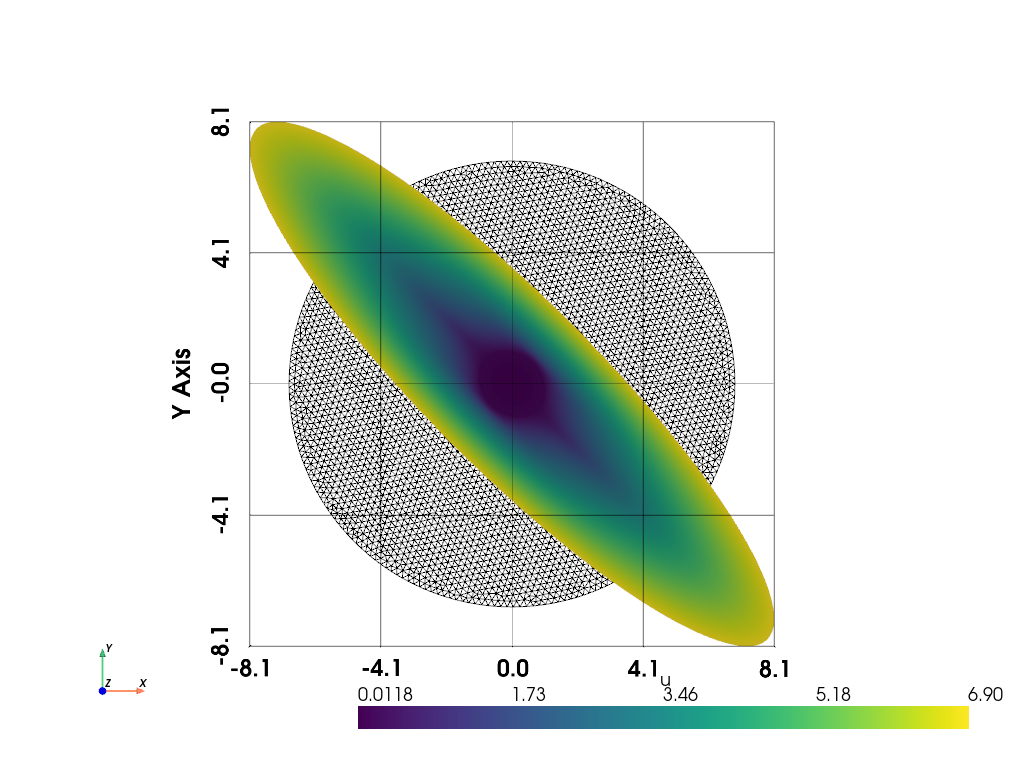

In [12]:
# Create pyvista grid
topology, cells, geometry = dolfinx.plot.vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# we add the mesh to the plot #grid is defined above
plotter.add_mesh(function_grid, show_edges=True, style="wireframe", color="k")

# add the deformed shape
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_solution)] = u_solution.x.array.reshape(geometry.shape[0], len(u_solution))
function_grid["u"] = values
function_grid.set_active_vectors("u")
warped = function_grid.warp_by_vector("u", factor=0.62) # Warp mesh by deformation
plotter.add_mesh(warped) # we add the deformed shape to the plot

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# 5) Export xdmf file and open it in Paraview

In [13]:
# To have a name in Paraview
u_solution.name = "displacement_vector"

In [14]:
# We export the mesh+solution to see it on Paraview
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/output.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(u_solution)

# 6) Compute the L2-norm of the solution

$ L^2_\text{norm} = \sqrt{\int_\Omega u^2 dx}$

In [15]:
# L2-norm of the solution
print('We compute the L2-norm of the solution')
print('For E_m = 0.8 , nu_m = 0.35 , E_i = 11.0 , nu_i = 0.3, R_i =1, R_e = 6.9, aspect_ratio = 1.0 , mesh_size = R_i/5, mesh_order = 1 ')
print('this norm should be equal to ~ 59')
np.sqrt( utils.assemble_scalar(dolfinx.fem.form(ufl.dot(u_solution,u_solution) * ufl.dx)))

We compute the L2-norm of the solution
For E_m = 0.8 , nu_m = 0.35 , E_i = 11.0 , nu_i = 0.3, R_i =1, R_e = 6.9, aspect_ratio = 1.0 , mesh_size = R_i/5, mesh_order = 1 
this norm should be equal to ~ 59


np.float64(59.04246761106802)

In [16]:
# On the diagonal x=y, u ~ -(x,x)*Emat/Einc in the inclusion
utils.evaluate_at_points(np.array([[0.2],[0.2],[0.0]]), u_solution)

array([[-0.02760466, -0.02748936]])

## 6.1) In the circular case, here is the analytical solution

In [17]:
import eshelby

In [18]:
from eshelby import EshelbyDisk
solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
u_ref_func = solution.to_function(R_i)

In [20]:
# analytical solution
utils.evaluate_at_points(np.array([[0.2],[0.2],[0.0]]), u_ref_func)

array([[-0.0280743 , -0.02807499]])

In [21]:
# FEM solution
utils.evaluate_at_points(np.array([[0.2],[0.2],[0.0]]), u_solution)

array([[-0.02760466, -0.02748936]])

# Are they equal? Why?

# 7) Compute the strain tensor of the solution

In [22]:
# We compute the strain tensor of the solution
eps_solution = eps(u_solution)

## Evaluating $ \epsilon_{ij} $

In [24]:
V_eps = fem.functionspace(domain, ("DG", 0))

In [25]:
eps_xx_expr = dolfinx.fem.Expression(eps_solution[0,0], V_eps.element.interpolation_points())
eps_xx = dolfinx.fem.Function(V_eps)
eps_xx.interpolate(eps_xx_expr)

In [26]:
# This should send back the strain at point (0.1,0.2)
utils.evaluate_at_points(np.array([[0.1],[0.2],[0.]]), eps_xx)

array([[7.87744755e-05]])

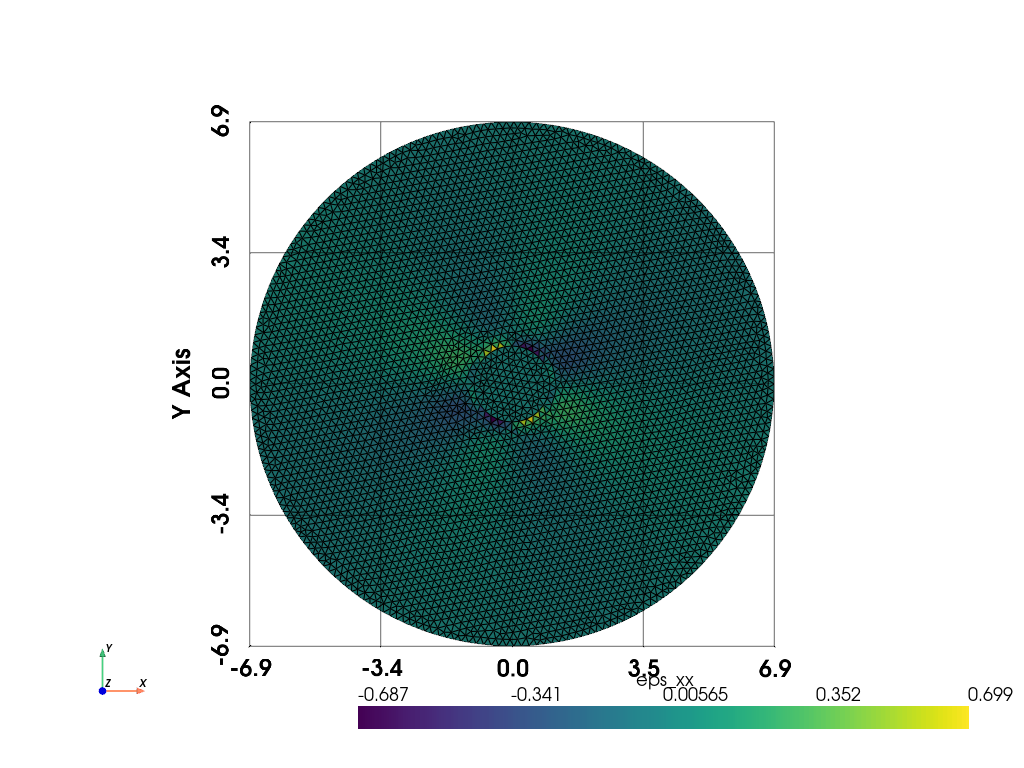

In [27]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# Add eps_xx(x,y)
function_grid["eps_xx"] = eps_xx.x.petsc_vec.array
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# 8) Do the same for $ \epsilon_{xy} $ and $ \epsilon_{yy} $ and

In [28]:
eps_xy_expr = dolfinx.fem.Expression(eps_solution[0,1], V_eps.element.interpolation_points())
eps_xy = dolfinx.fem.Function(V_eps)
eps_xy.interpolate(eps_xy_expr)

In [29]:
utils.evaluate_at_points(np.array([[0.5],[0.3],[0.]]), eps_xy)

array([[-0.14042059]])

In [30]:
# In the limit of a very large matrix, in the case of a circular inclusion,
# eps_xy(x,y) should be equal to
mu_m = E_m/(2*(1+nu_m))
mu_i = E_i/(2*(1+nu_i))
q = (3-4*nu_m)/(8*mu_m*(1-nu_m))
b = 1/(1+2*q*(mu_i-mu_m))
print('eps_xy_inclusion = ',-b)
# is it the case?

eps_xy_inclusion =  -0.13487629688747005


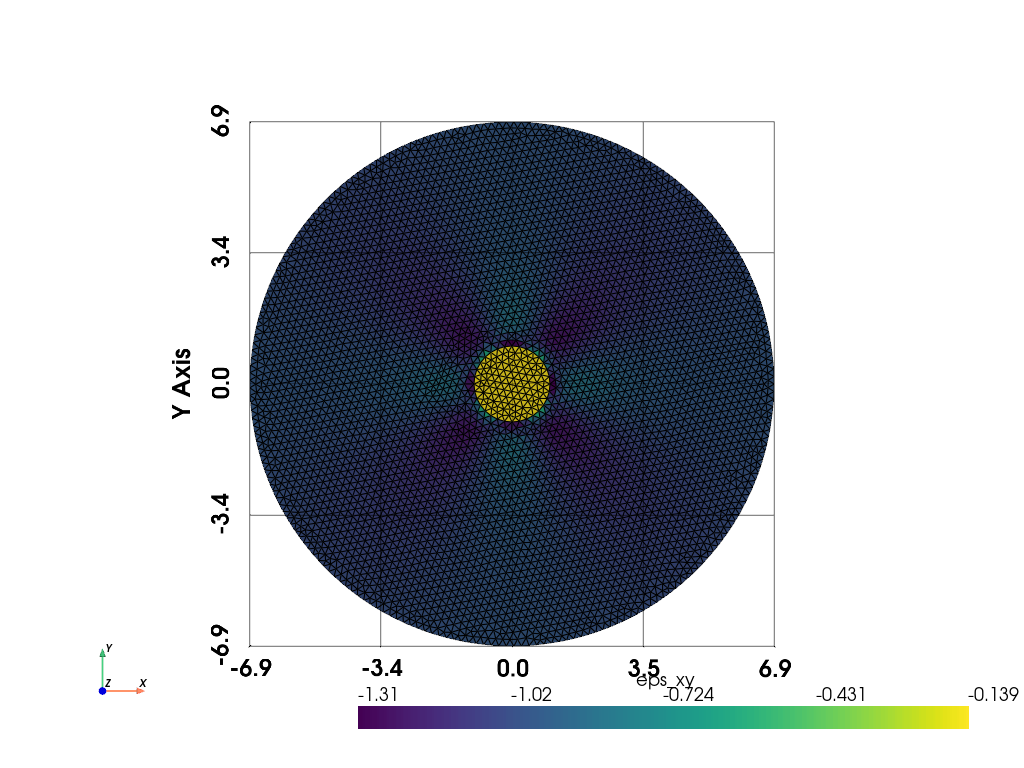

In [32]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# add eps_xy(x,y)
function_grid["eps_xy"] = eps_xy.x.petsc_vec.array
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

In [33]:
eps_yy_expr = dolfinx.fem.Expression(eps_solution[1,1], V_eps.element.interpolation_points())
eps_yy = dolfinx.fem.Function(V_eps)
eps_yy.interpolate(eps_yy_expr)

In [34]:
utils.evaluate_at_points(np.array([2.5,1.1,0.0]), eps_yy)

array([[0.09219897]])

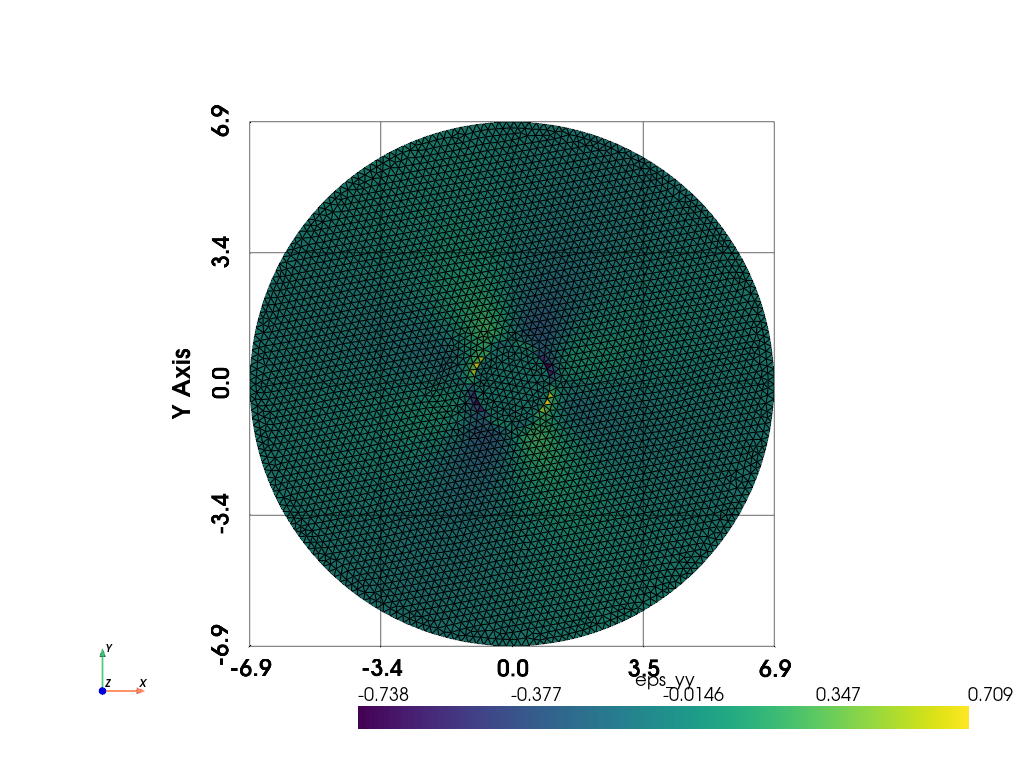

In [36]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# add eps_yy(x,y)
function_grid["eps_yy"] = eps_yy.x.petsc_vec.array
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

\begin{equation}
<\varepsilon_{ij}> = \frac{\int_\Omega \varepsilon_{ij} \,\mathrm{d}x}{ \int_\Omega dx }
\end{equation}

In [39]:
utils.assemble_scalar(eps_xx*dx) / area_domain

7.904218886830754e-18

In [40]:
utils.assemble_scalar(eps_xy*dx) / area_domain

-0.9999999999999915

In [42]:
utils.assemble_scalar(eps_yy*dx) / area_domain

-3.7720438300594266e-18

# 9.1) Compute mean values over inclusion

In [44]:
mean_eps_xx = utils.assemble_scalar(eps_xx*dx(1)) / area_inclusion
print(mean_eps_xx)

-1.4304196313418452e-05


In [46]:
mean_eps_xy = utils.assemble_scalar(eps_xy*dx(1)) / area_inclusion
print(mean_eps_xy)

-0.14247517552242286


## How does this mean value change when the ratio $E_{incl}/E_{mat}$ is changing ?

In [48]:
mean_eps_yy = utils.assemble_scalar(dolfinx.fem.form(eps_yy*dx(1))) / area_inclusion
print(mean_eps_yy)

-1.7202684715639736e-05


# 9.2) Compute mean values over matrix

In [49]:
utils.assemble_scalar(dolfinx.fem.form(eps_xx * dx(2))) / area_matrix

3.049245716242455e-07

In [50]:
utils.assemble_scalar(dolfinx.fem.form(eps_xy * dx(2))) / area_matrix

-1.0182799777089686

In [51]:
utils.assemble_scalar(dolfinx.fem.form(eps_yy * dx(2))) / area_matrix

3.6671205795610806e-07

# 9.5) Compute the deviation from uniformity inside inclusion

\begin{equation}
deviation = \frac{\int_\Omega Abs(\varepsilon_{ij} - <\varepsilon_{ij}>) \,\mathrm{d}x }{ <\varepsilon_{ij}> }
\end{equation}

### $\epsilon_{xx}$

In [53]:
print(mean_eps_xx)

-1.4304196313418452e-05


In [55]:
# Explain / comment the result
deviation_xx = utils.assemble_scalar(dolfinx.fem.form((abs(eps_xx-mean_eps_xx)*dx(1)))) / mean_eps_xx
print(deviation_xx)

-237.71222420931363


## $\epsilon_{xy}$

In [56]:
print(mean_eps_xy)

-0.14247517552242286


In [58]:
# Explain / comment the result
deviation_xy = utils.assemble_scalar(abs(eps_xy-mean_eps_xy)*dx(1)) / mean_eps_xy
print(deviation_xy)

-0.04264253165122552



### $\epsilon_{yy}$

In [59]:
print(mean_eps_yy)

-1.7202684715639736e-05


In [61]:
# Explain / comment the result
deviation_yy = utils.assemble_scalar(abs(eps_yy-mean_eps_yy)*dx(1)) / mean_eps_yy
print(deviation_yy)

-191.09333647983897


# 11) Plot u_y(x,0) using mathplotlib

## Making curve plots throughout the domain



We can evaluate a function on a point by using the  `uh.eval(points, cells)`, which requires the lists of cells where the points lie. To get this information we can use the following utility function, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_code.html

In [62]:
from dolfinx import fem, io, mesh, plot, geometry

def data_over_line(points, function):
    mesh = function.function_space.mesh
    comm = mesh.comm
    # comm
    bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(
        mesh, cell_candidates, points.T
    )
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc)

    if len(points_on_proc) > 0:
        values_on_proc = function.eval(points_on_proc, cells)
        point_data_proc = [points_on_proc.T, values_on_proc]
    else:
        point_data_proc = None

    point_data = comm.gather(point_data_proc, root=0)

    if comm.rank == 0:
        point_data = list(filter(None, point_data))
        # points = np.concatenate([data_proc[0].T for data_proc in point_data])
        values = np.concatenate([data_proc[1] for data_proc in point_data])
    else:
        point_data = None
        values = None
    return values

Defines the list of points, get the correspoding cells, and evaluate the function values

In [64]:
xs = np.linspace(0,R_e*0.9,90)
points = np.array([np.ones_like(xs), xs, np.zeros_like(xs)])
values = data_over_line(points,u_solution)

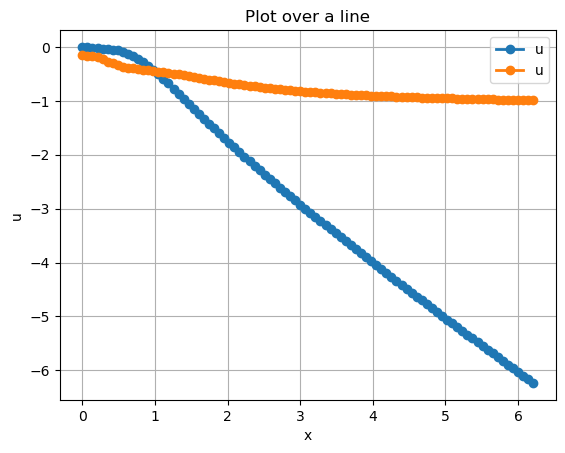

<Figure size 640x480 with 0 Axes>

In [65]:
fig = plt.figure()
plt.plot(points[1], values, "-o", linewidth=2, label="u")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Plot over a line")
plt.legend()
plt.show()
plt.savefig(f"output/line_plot.png")

# 12) Convergence study
How does the error decrease when the mesh size decreases?

If the mesh size is divided by 2, is the error also divided by 2?

Do the convergence exponents change when the inclusion is elliptical instead of circular?

# 13) Nondimensionalization
As usal for statics problems, we can freely choose a length unit, and a force unit.

Here we choose the length unit to be $R_i$, that is we set $R_i=1$.

We choose the force unit to be $E_m$, that is we set $E_m=1$.


###  13.1) We have set $R_e=6.9$ in our FEM computations. If, in the real world, the inclusion has radius $R_i=200$ microns, our FEM computations correspond to a matrix of which size? (6.9 microns, 6.9km, or 1.38 mm, or ... ?)

### 13.2) We have set $E_i = 11$ in our FEM computations. If, in the real world, the matrix has $E_m= 1.2$ GPa, our FEM computations correspond to an inclusion with which Young modulus? (11 GPa, or 13.2 GPa, ... ?)